In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import napari

In [2]:
movie = tiff.imread('data/multi_cell.tif')
cell1_data = tiff.imread('data/cell1.tif')
cell2_data = tiff.imread('data/cell2.tif')
cell3_data = tiff.imread('data/cell3.tif')

## Setting Up Napari with Conda and Loading Data

This section focuses on setting up a working Python environment for loading and annotating calcium imaging data. Using Conda, we will install Napari and supporting libraries and verify that imaging data can be loaded and visualized. 

```bash
conda create -n napari-env python=3.9 -y
conda activate napari-env
```

**Exercise** Install Napari and Required Libraries

```bash
pip install "napari[all]"
pip install tifffile numpy matplotlib
````


**Example** Load and play only the first 100 frames of `Cell 1`. Close the viewer once you are done.

In [ ]:
viewer = napari.Viewer()
viewer.add_image(cell1_data, name='Cell 1')

<Image layer 'Cell 1' at 0x22482817a70>

In [4]:
viewer.close()

In [5]:
viewer = napari.Viewer()
viewer.add_image(cell1_data[:100], name='Cell 1')

<Image layer 'Cell 1' at 0x224f05b3ec0>

In [6]:
viewer.close()

In [7]:
viewer = napari.Viewer()
viewer.add_image(cell1_data[1000:1010], name='Cell 1')

<Image layer 'Cell 1' at 0x224842f8fb0>

In [8]:
viewer.close()

## Labelling in napari

In [9]:
viewer = napari.Viewer()

**Example** Open mean projection of `cell1`

In [10]:
mean_proj = cell1_data.mean(axis=0)
viewer.add_image(mean_proj, name="Mean", colormap="gray")

<Image layer 'Mean' at 0x224828c56d0>

Add max projection of `Cell1` to an existing napari viewer

In [11]:
max_proj = cell1_data.max(axis=0)
viewer.add_image(max_proj, name="Max", colormap="gray")

<Image layer 'Max' at 0x22485df8470>

Add std projection of `Cell1` to an existing napari viewer

In [12]:
std_proj = cell1_data.std(axis=0)
viewer.add_image(std_proj, name="Std", colormap="gray")

<Image layer 'Std' at 0x22485df8050>

**Create a cell mask for Cell 1**
- Click on New Labels Layer and rename it as `roi`.
- Click the brush icon or press `B` to select the brush tool.
- Carefully paint over the cell body of the selected neuron.
- OR: Use the paint bucket tool to fill enclosed regions.

We can access the layers from the jupyter notebook directly without having to first export it to another file.

**Example** Access roi and plot it in the notebook.

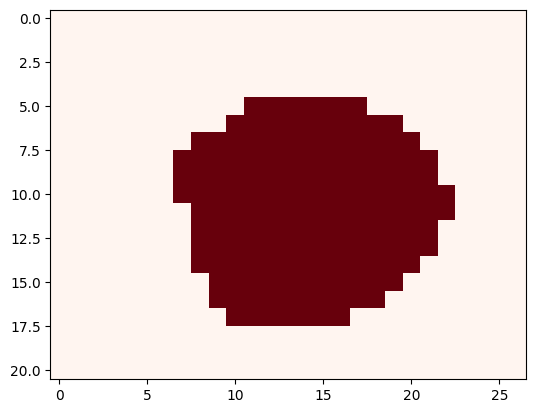

In [13]:
roi = viewer.layers['roi'].data
plt.imshow(roi, cmap='Reds');

Add/remove few pixels in napari from the roi layer. Access roi and plot here.

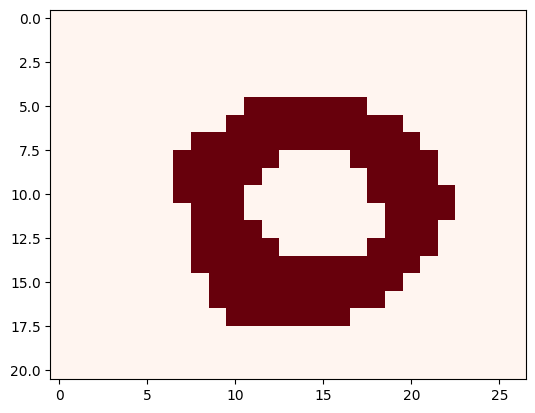

In [14]:
roi = viewer.layers['roi'].data
plt.imshow(roi, cmap='Reds');

Close viewer

In [17]:
viewer.close()

Napari can handle multiple neurons in a single Labels layer by treating neurons painted in different colors as a different neuron. The steps to identify multiple neurons in a single layer is below.

- Create a new labels layer.
- Select the brush tool: Press B to switch to the brush tool, or click the brush icon in the left toolbar.
- Set the brush size to small size:
   - Paint a rough outline of a neuron.
   - Carefully paint over the neuron body. 
- Move to the next label index:
   - Press M to increment the label index.
   - This will automatically update the label color, so the next neuron will appear in a new color.
- Repeat steps 2–6 for each neuron:
   - For each new neuron:
      - Paint its contour.
      - Use the fill tool to create a clean mask.
      - Press M to move to the next label index.
- Review all labeled ROIs: Zoom out and visually inspect the full image.


In [18]:
viewer = napari.Viewer()
viewer.add_image(movie.std(axis=0))

<Image layer 'Image' at 0x2248933c080>

Label multiple neurons in the summary image added in napari in a layer named `rois`.

In [19]:
rois = viewer.layers['rois'].data

**Example** Access the first neuron and plot it here.

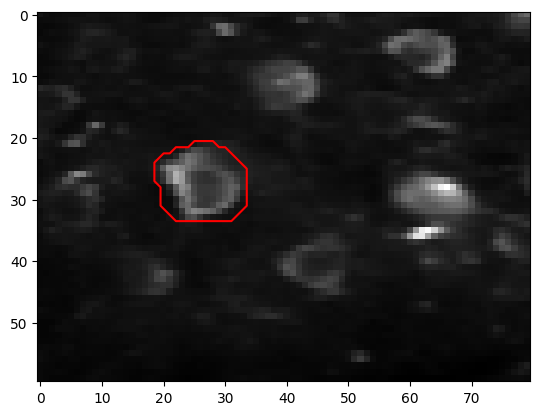

In [20]:
mask = (rois == 1)
plt.imshow(movie.std(axis=0), cmap='gray')
plt.contour(mask, colors='r')

Access second neuron and plot it here.

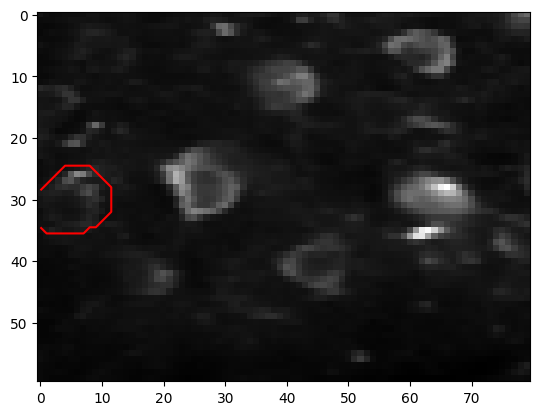

In [21]:
mask = (rois == 2)
plt.imshow(movie.std(axis=0), cmap='gray')
plt.contour(mask, colors='r')

Access the zeroth position and plot it here.

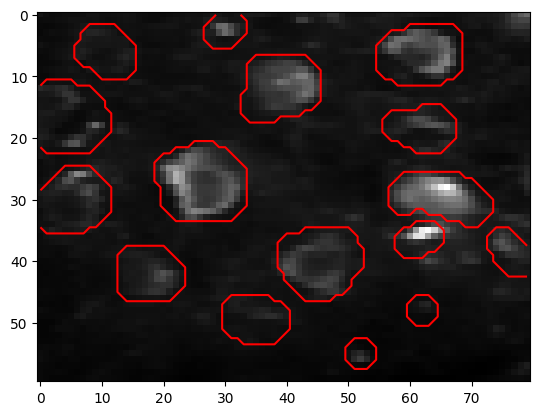

In [22]:
mask = (rois == 0)
plt.imshow(movie.std(axis=0), cmap='gray')
plt.contour(mask, colors='r')

How many neurons are labeled?

In [24]:
np.unique(rois)[-1]

16

What are the unique labels?

In [25]:
np.unique(rois)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

### **Isolating ROI Pixels**

To extract a trace for a given ROI, we must first identify which pixels it occupies in the field of view. This section focuses on converting labelled ROI data into binary masks—arrays that define the spatial footprint of each individual neuron. Using these masks, we can isolate and examine raw pixel values belonging to each ROI. 

With this mask, we can easily extract the calcium trace from a specific neuron with

```python
mask = rois == 1             # Create a boolean mask where pixels belonging to ROI 1 are True

movie[:, mask]              # Select only the ROI pixels at each time point ([frames, num_pixels_in_roi])

.mean(axis=1)               # Compute the average fluorescence across ROI pixels for each frame)
```

**Example** Plot calcium trace from 1st neuron.

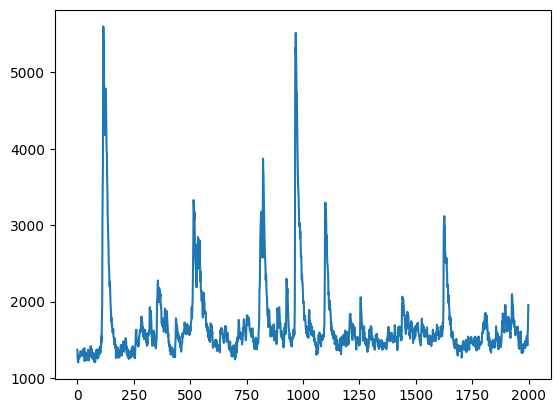

In [26]:
mask = rois == 1
cal_trace = movie[:, mask].mean(axis=1)
plt.plot(cal_trace)

Plot calcium trace from 2nd neuron.

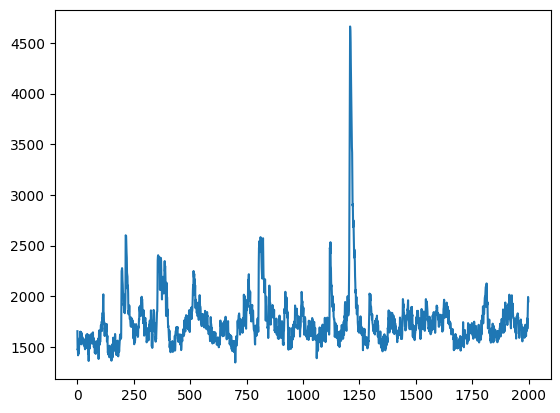

In [27]:
mask = rois == 2
cal_trace = movie[:, mask].mean(axis=1)
plt.plot(cal_trace)

Plot calcium trace from 3rd neuron.

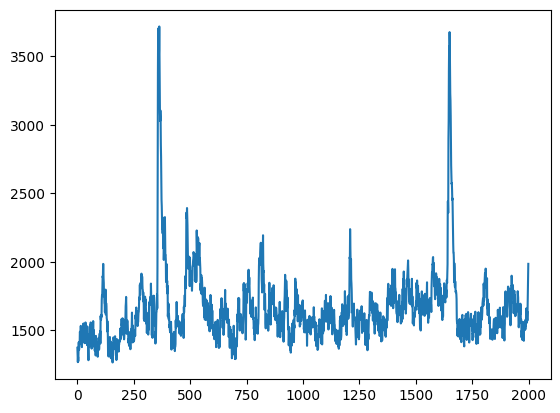

In [28]:
mask = rois == 3
cal_trace = movie[:, mask].mean(axis=1)
plt.plot(cal_trace)

### **Section 3 – Trace Extraction: Averaging ROI Pixels Over Time**

We usually have several neurons imaged simulataneously and they are all typically stored in a single matrix such that each row of that matrix represents calcium trace of a single neuron. In this section, we restructure the calcium traces extracted from our data into that format.

It involves three steps

- Initializing an zero-filled matrix of shape (n_rois x num_frames).
- Iteratively filling each row (roi) with its calcium trace.

**Example** Initialize `traces` to have space for two rois and all the frames.

In [29]:
n_frames = movie.shape[0]
traces = np.zeros((2, n_frames))
traces.shape

(2, 2000)

Initialize `traces` to have space for all rois and ten frames.

In [19]:
n_rois = len(np.unique(rois)) - 1
traces = np.zeros((n_rois, 10))
traces.shape

(14, 10)

Initialize `traces` to have space for all the rois and all the frames.

In [30]:
n_frames = movie.shape[0]
n_rois = np.unique(rois)[-1]
traces = np.zeros((n_rois, n_frames))
traces.shape

(16, 2000)

**Example** Add first trace to first row in `traces`

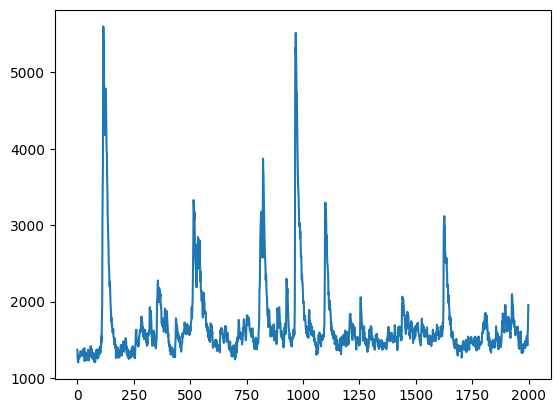

In [31]:
mask = rois == 1
trace = movie[:, mask].mean(axis=1)
traces[0] = trace
plt.plot(traces[0])

Add second trace to second row of `traces`.

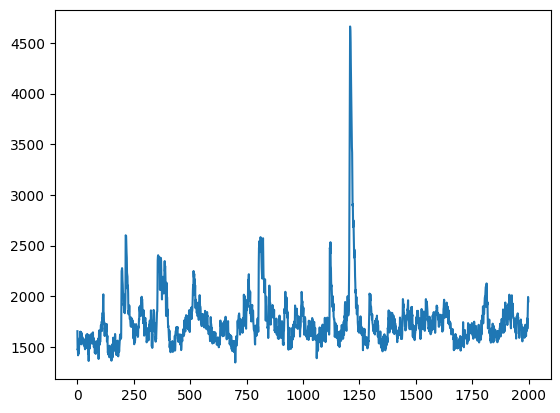

In [32]:
mask = rois == 2
trace = movie[:, mask].mean(axis=1)
traces[1] = trace
plt.plot(traces[1])

Add third trace to third location in `traces`.

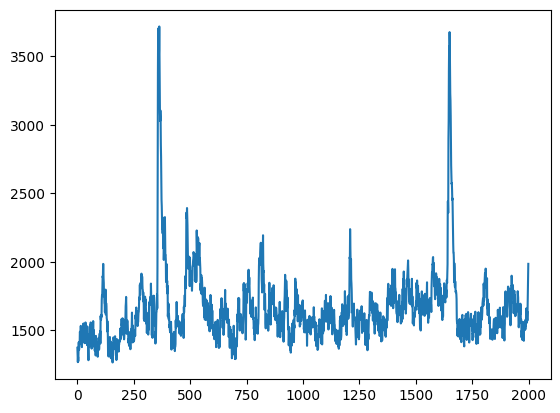

In [33]:
mask = rois == 3
trace = movie[:, mask].mean(axis=1)
traces[2] = trace
plt.plot(traces[2])

It can be tedious to do this manually especially when we have many number of neurons. We can use for-loop to do the same for multiple rois by

```python
traces = np.zeros((2, 2000))        # Create an empty array to store calcium traces for two ROIs (2 ROIs, 2000 frames)

for roi_num in range(1, 3):         # Loop through each ROI (1 and 2)
    mask = rois == roi_num          # Create a boolean mask for the current ROI
    trace = movie[:, mask].mean(axis=1)  # average fluorescence for the current ROI across all pixels at each time point
    traces[roi_num - 1] = trace     # Store the calcium trace for the current ROI in the 'traces' array
```

**Example** Use for loop to fill first two rois in their respective locations in `traces`.

In [34]:
traces = np.zeros((2, 2000))

for roi_num in range(1, 3):
    mask = rois == roi_num
    trace = movie[:, mask].mean(axis=1)
    traces[roi_num - 1] = trace

Use for loop to fill first three rois in their respective locations in `traces`.

In [35]:
traces = np.zeros((3, 2000))

for roi_num in range(1, 4):
    mask = rois == roi_num
    trace = movie[:, mask].mean(axis=1)
    traces[roi_num - 1] = trace

Use for loop to fill all rois in their respective locations in `traces`.

In [36]:
roi_nums = len(np.unique(rois))
traces = np.zeros((roi_nums, 2000))

for roi_num in range(1, roi_nums):
    mask = rois == roi_num
    trace = movie[:, mask].mean(axis=1)
    traces[roi_num - 1] = trace

### **Section 4 – Interpreting and Visualizing Extracted Traces**

This section introduces simple plotting tools to inspect both individual traces and full populations of neurons. Visualization helps verify the success of the extraction process, and also offers a first glimpse into the temporal structure of the data. 

**Example** Plot location and trace of neuron 1.

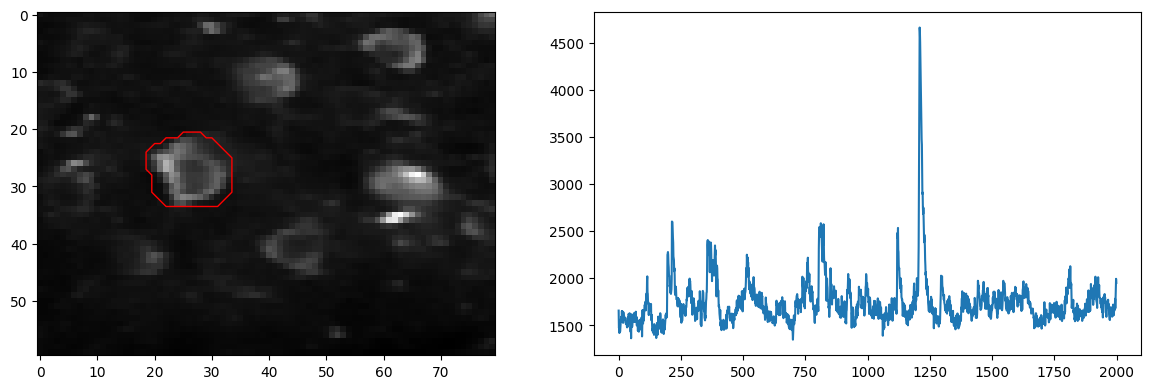

In [37]:
roi_num = 1
summary_image = movie.std(axis=0)
mask = rois == roi_num

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(summary_image, cmap='gray')
axes[0].contour(mask, colors='red', linewidths=1)

axes[1].plot(traces[roi_num])

plt.tight_layout()

Plot location and trace of neuron 2.

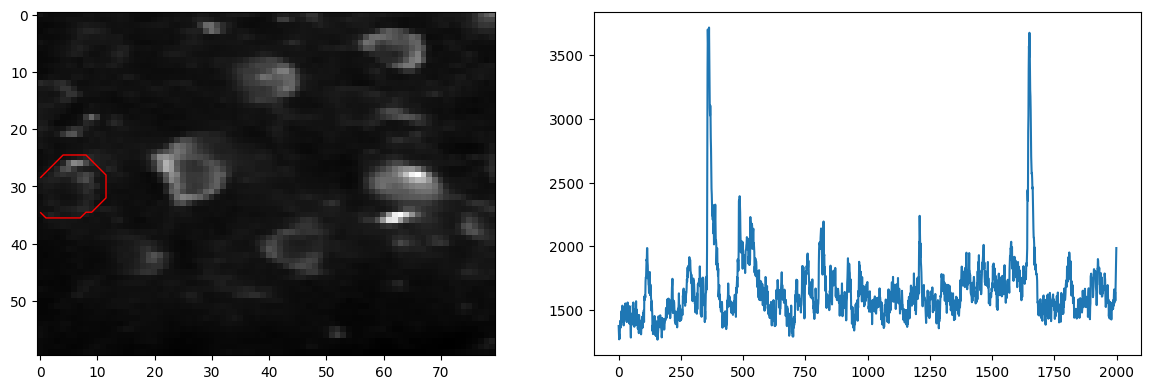

In [38]:
roi_num = 2
summary_image = movie.std(axis=0)
mask = rois == roi_num

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(summary_image, cmap='gray')
axes[0].contour(mask, colors='red', linewidths=1)

axes[1].plot(traces[roi_num])

plt.tight_layout()

Plot location and trace of neuron 3.

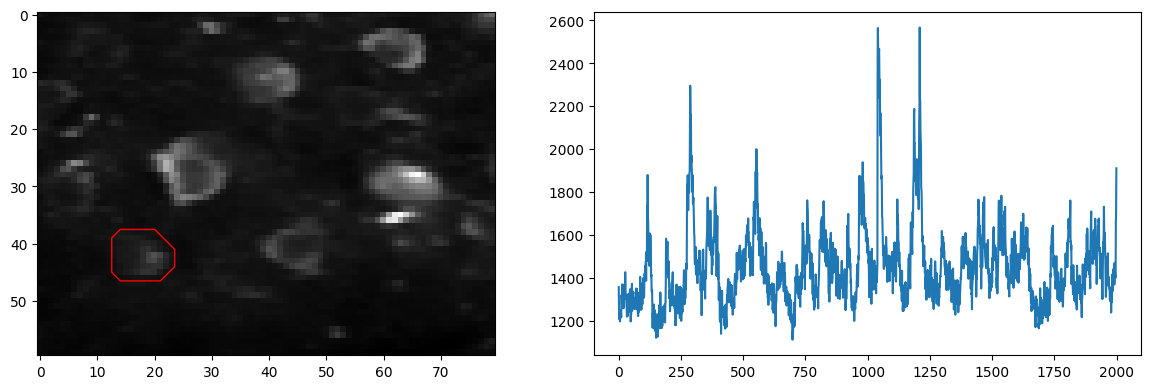

In [39]:
roi_num = 3
summary_image = movie.std(axis=0)
mask = rois == roi_num

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(summary_image, cmap='gray')
axes[0].contour(mask, colors='red', linewidths=1)

axes[1].plot(traces[roi_num])

plt.tight_layout()

(**DEMO**) Interactive plot

In [40]:
%matplotlib inline

from ipywidgets import interact, IntSlider
import ipywidgets as widgets


roi_nums = np.unique(rois)[1:]
summary_image = movie.std(axis=0)

def plot_neuron_trace(roi_idx):
    mask = rois == roi_idx

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(summary_image, cmap='gray')
    axes[0].contour(mask, colors='red', linewidths=1)
    axes[0].set_title(f"ROI {roi_idx} Location")
    axes[0].axis("off")

    axes[1].plot(traces[roi_idx - 1])
    axes[1].set_title(f"Fluorescence Trace (ROI {roi_idx})")
    axes[1].set_xlabel("Frame")
    axes[1].set_ylabel("Fluorescence")

    plt.tight_layout()
    plt.show()

interact(plot_neuron_trace, roi_idx=IntSlider(min=1, max=len(roi_nums), step=1, value=0));


interactive(children=(IntSlider(value=1, description='roi_idx', max=16, min=1), Output()), _dom_classes=('widg…